# Binary classification

<a id='contents'></a>
## Contents

* [Overview](#overview)
* [Metrics](#metrics)
* [Setup, packages, and loading data](#setup_packages)
* [Training/validation split](#trainingvalidation)
* [Trivial predictions and baseline metrics](#trivial_predictions)
* [Non-trivial predictions](#non-trivial)
* [Model evaluation](#model_evaluation)
* [Viewing some images, with predictions](#viewing_some)

<a id='overview'></a>
## Overview
↑↑ [Contents](#contents) ↓ [Metrics](#metrics)

We'll perform some binary classification tasks, including melanoma (```mel```) versus not melanoma, and nevus (```nv```) versus not nevus. We first discuss metrics for each task, then obtain baseline metrics through trivial predictions. Finally, we train some CNNs with fast.ai/PyTorch. We make use of Google Colab GPUs for training, then export/import the results here for evaluation.

<a id='metrics'></a>
## Metrics
↑↑ [Contents](#contents) ↑ [Overview](#overview) ↓ [Setup, packages, and loading data](#setup_packages)

We'll discuss metrics in the context of our melanoma versus not melanoma task for concreteness, but in the formulas below one can essentially replace all occurrences of "lesion" with "label" and "melanoma" with "positive" ("non-melanoma" with "negative"). The upshot is that our main metric will be $F_{\beta}$ score, with $\beta = 2$ in the case of malignant lesions, and $\beta = 1/2$ in the case of benign lesions. We will also use the Matthews correlation coefficient (MCC) as a secondary metric.

* $\text{P}$ (positive): lesion is melanoma
* $\text{N}$ (negative): lesion is not melanoma
* $\text{PP}$ (predicted positive): lesion is predicted to be melanoma
* $\text{PN}$ (predicted negative): lesion is predicted to be non-melanoma
* $\text{tp}$ (true positive): number of correctly-predicted melanoma
* $\text{tn}$ (true negative): number of correctly-predicted non-melanoma
* $\text{fp}$ (false positive): number of incorrectly-predicted melanoma (i.e. non-melanoma misclassified as melanoma)
* $\text{fn}$ (false negative): number of incorrectly-predicted non-melanoma (i.e. melanoma misclassified as non-melanoma)

Misclassifying an aggressive malignancy like melanoma may result in delayed or inappropriate treatment, hence worse outcomes for patients as well as greater healthcare costs. Our highest priority is therefore to maximize 

\begin{equation}
\text{recall} = \mathbb{P}(\text{PP} \mid \text{P}) = \frac{\# \text{correctly-predicted melanoma}}{\# \text{melanoma}} = \frac{\text{tp}}{\text{tp} + \text{fn}}. \tag{1}
\end{equation}

On the other hand, misclassifying a non-melanoma as a melanoma may result in unnecessary/inappropriate care (e.g. unnecessary biopsies), hence unnecessary healthcare costs, not to mention unduly concerning a patient. Therefore, maximizing 

\begin{equation}
\text{precision} = \mathbb{P}(\text{P} \mid \text{PP}) = \frac{\# \text{correctly-predicted melanoma}}{\# \text{predicted melanoma}} = \frac{\text{tp}}{\text{tp} + \text{fp}}. \tag{2}
\end{equation}

is also a priority, but one which we place below maximizing recall.

Given a real parameter $\beta$, and assuming recall and precision are defined and positive, let

\begin{equation}
F_{\beta} = \frac{\beta^2 + 1}{\frac{\beta^2}{\text{recall}} + \frac{1}{\text{precision}}} =  \frac{(\beta^2 + 1)(\#\text{correctly-predicted melanoma})}{\beta^2 (\# \text{melanoma}) + \# \text{predicted melanoma}} = \frac{(1 + \beta^2)\text{tp}}{(1 + \beta^2)\text{tp} + \text{fp} + \beta^2\text{fn}}, \tag{3}
\end{equation}

the weighted harmonic mean of recall and precision, with the ratio of the recall weight to the precision weight being $\beta^2$. Note that 

\begin{equation}
F_0 = \lim_{\beta \to 0} F_{\beta} = \text{precision}, \quad \text{while} \quad F_{\infty} := \lim_{\beta \to \infty} F_{\beta} = \text{recall}. \tag{4}
\end{equation}

As long as our validation set contains at least one melanoma, and our model predicts at least one melanoma among our validation set, recall, precision, and $F_{\beta}$ will all be defined and lie in $[0,1]$, all three being equal to $1$ if and only if our prediction is "perfect" (no false positives and no false negatives).

Given our priorities, if we are to assess or model by a single metric, it seems reasonable to select an $F_{\beta}$-score with $\beta > 1$ (emphasizing recall over precision). We select $\beta = 2$.

The **trivial prediction** in this task is that "all lesions are melanoma", in which case 

\begin{align*}
\# \text{predicted melanoma} & = \# \text{predictions} \\
\# \text{correctly-predicted melanoma} & = \# \text{melanoma},
\end{align*}

so that, as long as $\# \text{melanoma} \ne 0$, 

\begin{align*}
\text{recall} & = 1 \\
\text{precision} & = \frac{\# \text{melanoma}}{\# \text{predictions}} \\
F_{\beta} & = \frac{(\beta^2 + 1)(\# \text{melanoma})}{(\beta^2 + 1)(\# \text{melanoma}) + \# \text{non-melanoma}}. \tag{5}
\end{align*}

As we will see, the $F_2$ score we obtain is fairly low, but this is only because our dataset is imbalanced, with a paucity melanoma diagnoses. If the balance were in favor of melanoma, then the $F_2$ score would be much higher. Notwithstanding, this gives us a baseline: a model is otiose unless it yields a higher $F_2$ score than the trivial prediction.

The [Matthews correlation coefficient](https://en.wikipedia.org/wiki/Phi_coefficient) (MCC) is often considered an appropriate metric in the case of imbalanced datasets such as ours. The MCC is a correlation coefficient between the observed and predicted binary classifications; it returns a value between $−1$ and $+1$. A coefficient of $+1$ represents a perfect prediction, $0$ no better than random prediction and $−1$ indicates total disagreement between prediction and observation. One formulation is as follows:

\begin{equation}
\text{MCC} = \frac{\text{tp}\times\text{tn} - \text{fp}\times\text{fn}}{\sqrt{(\text{tp} + \text{fp})(\text{tp} + \text{fn})(\text{tn} + \text{fp})(\text{tn} + \text{fn})}}. \tag{6}
\end{equation}

If exactly one of the four sums in the denominator is zero, the denominator can be arbitrarily set to one; this results in a Matthews correlation coefficient of zero, which can be shown to be the correct limiting value. In case two or more sums are zero (e.g. both labels and model predictions are all positive or negative), the limit does not exist.

Thus, if we have both positive- and negative-labeled data, the trivial predictions "all positive" and "all negative" will yield $\text{MCC} = 0$ (no better than random guessing).

As for our nevus/non-nevus classification: in contrast to melanoma, nevi are benign and require no treatment. Therefore, it's hard to imagine anything worse than an unnecessary low-risk biopsy as a result of the misclassification of a nevus. On the other hand, the misclassification of a pre-cancerous/malignant lesion (e.g. melanoma) as a benign nevus could have devastating consequences.  

Thus, in this task, as in melanoma versus not melanoma classification, we are still interesed in recall and precision, but our priorities are reversed. That is, precision is more important than recall, and so our metric will be $F_{\beta}$ score with $\beta < 1$. We shoose $\beta = 1/2$.

Formulas $(1)$ through $(6)$ still hold here: we simply replace $\text{melanoma}$ with $\text{nevus}$ throughout.

As almost 75% of distinct lesions in our dataset are nevi, the trivial prediction ("all lesions are nevi") in this case will result in much better precision than in the melanoma case above. This illustrates, even more emphatically, why metrics must be chosen and interpreted carefully when appraising a model. More appropriately, the Matthews Correlation Coefficient in this case is again $0$ (no better than random guessing).

<a id='setup_packages'></a>
## Setup, packages, and loading data
↑↑ [Contents](#contents) ↑ [Metrics](#metrics) ↓ [Training/validation split](#trainingvalidation)

In [1]:
# Toggle True if using Colab, False if not.
using_colab = False

if using_colab:
    ! [ -e /content ] && pip install -Uqq fastbook

In [2]:
from fastbook import *
# from fastai.vision.all import *
# from fastai.torch_basics import *
# fastbook includes pandas and numpy, so if it's imported, the
# next two lines are redundant.
# import pandas as pd
# import numpy as np
import pathlib

In [3]:
# Paths

if not using_colab:
    path_to_data = '.\\data\\'
    path_to_images = '.\\images\\'
    path_to_models = '.\\models\\'
else:
    from google.colab import drive
    drive.mount('/content/drive')
    path_to_data = Path('/content/drive/My Drive/Colab Notebooks/data/')
    path_to_images = Path('/content/drive/My Drive/Colab Notebooks/images/')
    path_to_models = Path('/content/drive/My Drive/Colab Notebooks/models/')

In [413]:
# Read metadata csv into pandas dataframe
if using_colab:
    metadata = pd.read_csv(path_to_data/'00_metadata.csv')
else:
    metadata = pd.read_csv(path_to_data + '00_metadata.csv')

# Add a column giving multiplicity (no. of images) of each lesion
metadata_duplicates = metadata[metadata.duplicated(subset='lesion_id')].sort_values('lesion_id')
metadata.insert(1,'no_of_images', metadata['lesion_id'].map(metadata['lesion_id'].value_counts()))

metadata.head()

,lesion_id,no_of_images,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,2,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,2,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,2,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,2,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,2,ISIC_0031633,bkl,histo,75.0,male,ear


<a id='trainingvalidation'></a>
## Training/validation split
↑↑ [Contents](#contents) ↑ [Setup, packages, and loading data](#setup_packages) ↓ [Trivial predictions and baseline metrics](#trivial_predictions)

We partition our dataset based on ```lesion_id```, so that every lesion will be represented in exactly one set (training set or validation set), and no lesion will have an image in the training set if it has one in the validation set, and vice-versa. 

We consider two ways to train/validate our models, subject to the above condition. Namely, we can consider precisely one image per lesion (as in ```partition_dist```), or we can incorporate all images, i.e. possibly multiple images of each lesion (as in ```partition_mult```). Accordingly, we will make two copies of our ```metadata``` table, and add to each a 'partition' column, which will indicate the partition each image is assigned to ('train', 'val', or ```<NA>``` [none]).

In the case where we select exactly one image per lesion, we have a choice as to which image.For each distinct lesion, we can choose the first image in our table, or if this isn't random enough, we can choose a random image of the lesion.

We specify the target ratio of the number of distinct lesions in the training set to the number of distinct lesions in the validation set. Whether we select one image per lesion or all images per lesion, the training/validation set ratio will be close to this target ratio. We also check that the distribution of diagnoses is roughly the same across training and validation sets.

In [419]:
partition_dist = metadata.copy(deep=True)
partition_mult = metadata.copy(deep=True)

# Add a column that will identify the partition an image will belong to (train/val/none)
partition_dist['partition'] = pd.NA
partition_mult['partition'] = pd.NA

# Approximate training set to validation set ratio:
train_val_ratio = 3

# Collect distinct lesions
distinct_lesions = metadata['lesion_id'].unique()
# Determine the number of distinct lesions to be represented in the training set
distinct_lesions_train_size = int(distinct_lesions.shape[0]*(1/(1 + 1/train_val_ratio)))
# Randomly select that many distinct lesions to be represented in our training set, with the rest to be represented in our validation set.
np.random.seed(0)
distinct_lesions_train = np.random.choice(distinct_lesions, distinct_lesions_train_size, replace = False)
distinct_lesions_val = distinct_lesions[~np.isin(distinct_lesions, distinct_lesions_train)]

print('='*39 + '\n' + 'Distinct lesions, one image per lesion.'.upper() + '\n' + '='*39 + '\n')   
keep_first = False 
if keep_first: # Keep first image of each lesion
    print('When there is more than one image for a lesion, we keep the first corresponding image in our dataframe.\n')
    dist_images_train = metadata[metadata['lesion_id'].isin(distinct_lesions_train)].drop_duplicates(subset=['lesion_id'], keep='first')['image_id']   
    dist_images_val = metadata[metadata['lesion_id'].isin(distinct_lesions_val)].drop_duplicates(subset=['lesion_id'], keep='first')['image_id']   
else: # Keep a random image of each lesion
    print('When there is more than one image for a lesion, we keep a random corresponding image in our dataframe.\n')
    dist_images_train = metadata[metadata['lesion_id'].isin(distinct_lesions_train)].sample(frac=1, random_state=0).drop_duplicates(subset=['lesion_id'], keep='first')['image_id']         
    dist_images_val = metadata[metadata['lesion_id'].isin(distinct_lesions_val)].sample(frac=1, random_state=0).drop_duplicates(subset=['lesion_id'], keep='first')['image_id']         

print(f'Total data points: {dist_images_train.shape[0] + dist_images_val.shape[0]}.')
print(f'Training set size: {dist_images_train.shape[0]} ({100*dist_images_train.shape[0]/(dist_images_train.shape[0] + dist_images_val.shape[0]):.2f}%).')
print(f'Validation set size: {dist_images_val.shape[0]} ({100*dist_images_val.shape[0]/(dist_images_train.shape[0] + dist_images_val.shape[0]):.2f}%).\n')
    
partition_dist.loc[partition_dist['image_id'].isin(dist_images_train),'partition'] = 'train'
partition_dist.loc[partition_dist['image_id'].isin(dist_images_val),'partition'] = 'val'

print('Dataframe: partition_dist\n')
display(partition_dist.head())

print('\nDiagnosis breakdown\n'.upper())
A = partition_dist[partition_dist['partition'].notnull()]['dx']
B = partition_dist[partition_dist['partition'] == 'train']['dx']
C = partition_dist[partition_dist['partition'] == 'val']['dx']
for text, col in zip(['Overall', 'Training set', 'Validation set'],[A,B,C]):
    print(text.upper())
    dx_breakdown_dist = pd.concat([col.value_counts(), col.value_counts(normalize=True).mul(100).round(2)],axis=1, keys=['freq', '%'])
    dx_breakdown_dist.index.names = ['dx']
    display(dx_breakdown_dist.T)
    
print('\n')    
print('='*91 + '\n' + 'Multiple images per lesion, but any given lesion\'s images all lie in exactly one partition.'.upper() + '\n' + '='*91 + '\n')
mult_images_train = metadata[metadata['lesion_id'].isin(distinct_lesions_train)]['image_id']
mult_images_val = metadata[metadata['lesion_id'].isin(distinct_lesions_val)]['image_id']

print(f'Total data points: {mult_images_train.shape[0] + mult_images_val.shape[0]}.')
print(f'Training set size: {mult_images_train.shape[0]} ({100*mult_images_train.shape[0]/(mult_images_train.shape[0] + mult_images_val.shape[0]):.2f}%).')
print(f'Validation set size: {mult_images_val.shape[0]} ({100*mult_images_val.shape[0]/(mult_images_train.shape[0] + mult_images_val.shape[0]):.2f}%).\n')
    
partition_mult.loc[partition_mult['image_id'].isin(mult_images_train),'partition'] = 'train'
partition_mult.loc[partition_mult['image_id'].isin(mult_images_val),'partition'] = 'val'

print('Dataframe: partition_mult\n')
display(partition_mult.head())

print('\nDiagnosis breakdown\n'.upper())
A = partition_mult['dx']
B = partition_mult[partition_mult['partition'] == 'train']['dx']
C = partition_mult[partition_mult['partition'] == 'val']['dx']
for text, col in zip(['Overall', 'Training set', 'Validation set'],[A,B,C]):
    print(text.upper())
    dx_breakdown_mult = pd.concat([col.value_counts(), col.value_counts(normalize=True).mul(100).round(2)],axis=1, keys=['freq', '%'])
    dx_breakdown_mult.index.names = ['dx']
    display(dx_breakdown_mult.T)

DISTINCT LESIONS, ONE IMAGE PER LESION.

When there is more than one image for a lesion, we keep a random corresponding image in our dataframe.

Total data points: 7470.
Training set size: 5602 (74.99%).
Validation set size: 1868 (25.01%).

Dataframe: partition_dist



,lesion_id,no_of_images,image_id,dx,dx_type,age,sex,localization,partition
0,HAM_0000118,2,ISIC_0027419,bkl,histo,80.0,male,scalp,<NA>
1,HAM_0000118,2,ISIC_0025030,bkl,histo,80.0,male,scalp,val
2,HAM_0002730,2,ISIC_0026769,bkl,histo,80.0,male,scalp,<NA>
3,HAM_0002730,2,ISIC_0025661,bkl,histo,80.0,male,scalp,train
4,HAM_0001466,2,ISIC_0031633,bkl,histo,75.0,male,ear,<NA>



DIAGNOSIS BREAKDOWN

OVERALL


dx,nv,bkl,mel,bcc,akiec,vasc,df
freq,5403.00,727.00,614.00,327.00,228.00,98.00,73.00
%,72.33,9.73,8.22,4.38,3.05,1.31,0.98


TRAINING SET


dx,nv,bkl,mel,bcc,akiec,vasc,df
freq,4024.00,554.00,476.0,251.00,170.00,75.00,52.00
%,71.83,9.89,8.5,4.48,3.03,1.34,0.93


VALIDATION SET


dx,nv,bkl,mel,bcc,akiec,vasc,df
freq,1379.00,173.00,138.00,76.00,58.0,23.00,21.00
%,73.82,9.26,7.39,4.07,3.1,1.23,1.12




MULTIPLE IMAGES PER LESION, BUT ANY GIVEN LESION'S IMAGES ALL LIE IN EXACTLY ONE PARTITION.

Total data points: 10015.
Training set size: 7519 (75.08%).
Validation set size: 2496 (24.92%).

Dataframe: partition_mult



,lesion_id,no_of_images,image_id,dx,dx_type,age,sex,localization,partition
0,HAM_0000118,2,ISIC_0027419,bkl,histo,80.0,male,scalp,val
1,HAM_0000118,2,ISIC_0025030,bkl,histo,80.0,male,scalp,val
2,HAM_0002730,2,ISIC_0026769,bkl,histo,80.0,male,scalp,train
3,HAM_0002730,2,ISIC_0025661,bkl,histo,80.0,male,scalp,train
4,HAM_0001466,2,ISIC_0031633,bkl,histo,75.0,male,ear,train



DIAGNOSIS BREAKDOWN

OVERALL


dx,nv,mel,bkl,bcc,akiec,vasc,df
freq,6705.00,1113.00,1099.00,514.00,327.00,142.00,115.00
%,66.95,11.11,10.97,5.13,3.27,1.42,1.15


TRAINING SET


dx,nv,mel,bkl,bcc,akiec,vasc,df
freq,4999.00,865.0,837.00,390.00,240.00,109.00,79.00
%,66.48,11.5,11.13,5.19,3.19,1.45,1.05


VALIDATION SET


dx,nv,bkl,mel,bcc,akiec,df,vasc
freq,1706.00,262.0,248.00,124.00,87.00,36.00,33.00
%,68.35,10.5,9.94,4.97,3.49,1.44,1.32


<a id='trivial_predictions'></a>
## Trivial predictions and baseline metrics
↑↑ [Contents](#contents) ↑ [Training/validation split](#trainingvalidation) ↓ [Non-trivial predictions](#non-trivial)

We can use $(1)$ through $(6)$ [above](#metrics) to compute metrics for the trivial prediction whereby all labels are positive (i.e. all lesions are melanoma, or all lesions are nevi, etc.). However, in anticipation of the evaluation of non-trivial models, let us define some helper functions here.

In [6]:
def key_metrics(preds, targs, BETA=[1,2]):
    '''
    INPUTS
    - preds: array of shape (n,) or (n,1). Elements are all 1/0 (or equivalent, e.g. True/False).
    - targs: array of shape (n,) or (n,1). Elements are all 1/0 (or equivalent, e.g. True/False).
    - BETA: list of floats
    
    OUTPUT 
    - output:  dictionary with keys 'P', 'N', etc., as below, and
      values equal to number of 1's (or equivalent) in target, etc.    
    '''
    output = {'P' : None, 'N': None, 'PP' : None, 'PN': None, 
              'tp' : None, 'tn' : None, 'fp': None, 'fn' : None, 
              'recall' : None, 'precision' : None, 
              'f' : { beta : None for beta in BETA }, 'MCC' : None }
    code = 2*preds + targs
    # tp: pred = 1 and targ = 1, code = 2*1 + 1 = 3
    # fp: pred = 1 and targ = 0, code = 2*1 + 0 = 2
    # fn: pred = 0 and targ = 1, code = 2*0 + 1 = 1
    # tn: pred = 0 and targ = 0, code = 2*0 + 0 = 0    
    tp = np.sum(code == 3)
    tn = np.sum(code == 0)
    fp = np.sum(code == 2)
    fn = np.sum(code == 1)
    output['P'] = tp + fn
    output['N'] = tn + fp
    output['PP'] = tp + fp
    output['PN'] = tn + fn
    output['tp'] = tp
    output['tn'] = tn
    output['fp'] = fp
    output['fn'] = fn
    if tp + fn != 0:
        output['recall'] = tp/(tp + fn)
    if tp + fp != 0:
        output['precision'] = tp/(tp + fp)    
    if tp + fn != 0 and tp + fp != 0:
        recall = output['recall']
        precision = output['precision']
        for beta in BETA:
            fbeta = (beta**2 + 1)/((beta**2/recall) + (1/precision))
            output['f'][beta] = fbeta
    # MCC
    numerator = tp*tn - fp*fn
    denominator_terms = np.array([tp + fp, tp + fn, tn + fp, tn + fn]).astype(np.float64)
    if np.sum(denominator_terms == 0) == 0:
        denominator = np.sqrt(np.prod(denominator_terms))
        output['MCC'] = numerator/denominator
    elif np.sum(denominator_terms == 0) == 1:
        output['MCC'] = numerator
    return output

For malignant lesions, our main metric will be $F_{2}$ score. For benign lesions, it will be $F_{1/2}$ score. Let's partition diagnoses into benign and malignant now, then see ```key_metrics``` applied to three malignant and two benign lesions.

In [7]:
benign = ['bkl', 'nv', 'vasc', 'df']
malignant = ['mel', 'bcc', 'akiec']
dx_considered = ['mel', 'bcc', 'akiec', 'bkl', 'nv']

In [8]:
for i in [0,1]:
    if i == 0:
        df = partition_dist
        print('='*20 + '\n' + 'One image per lesion'.upper() + '\n' + '='*20)
    else:
        df = partition_mult
        print('\n' + '='*26 + '\n' + 'Multiple images per lesion'.upper() + '\n' + '='*26)
    for pos_label in dx_considered:
        print(f'\nBinary classification {pos_label}/not. Trivial prediction: all lesions are {pos_label}.\n'.upper())
        print(f'\tRECALL: {1}')
        P = df[(df['partition'] == 'val') & (df['dx'] == pos_label)].shape[0]
        N = df[df['partition'] == 'val'].shape[0] - P
        precision = P/(P + N)
        print(f'\tPRECISION: {precision:.4f}')
        if pos_label in malignant:
            BETA = [1,2]
        else:
            BETA = [1/2,1]
        for beta in BETA:
            F_beta = (beta**2 + 1)*P/((beta**2 + 1)*P + N)
            if beta == 1/2:
                print('\tF_' + '{1/2}' + f': {F_beta:.4f}')
            else:
                print(f'\tF{beta}: {F_beta:.4f}')
        print('\tMCC: 0')
        print('\t----------')
        targs = df[df['partition'] == 'val']['dx'] == pos_label
        preds = np.ones(targs.shape[0])
        metrics = key_metrics(preds, targs, BETA)
        for k in ['P', 'N', 'PP', 'PN', 'tp', 'fp', 'fn', 'tn']:
            print(f'\t{k}: {metrics[k]}')

ONE IMAGE PER LESION

BINARY CLASSIFICATION MEL/NOT. TRIVIAL PREDICTION: ALL LESIONS ARE MEL.

	RECALL: 1
	PRECISION: 0.0739
	F1: 0.1376
	F2: 0.2851
	MCC: 0
	----------
	P: 138
	N: 1730
	PP: 1868
	PN: 0
	tp: 138
	fp: 1730
	fn: 0
	tn: 0

BINARY CLASSIFICATION BCC/NOT. TRIVIAL PREDICTION: ALL LESIONS ARE BCC.

	RECALL: 1
	PRECISION: 0.0407
	F1: 0.0782
	F2: 0.1750
	MCC: 0
	----------
	P: 76
	N: 1792
	PP: 1868
	PN: 0
	tp: 76
	fp: 1792
	fn: 0
	tn: 0

BINARY CLASSIFICATION AKIEC/NOT. TRIVIAL PREDICTION: ALL LESIONS ARE AKIEC.

	RECALL: 1
	PRECISION: 0.0310
	F1: 0.0602
	F2: 0.1381
	MCC: 0
	----------
	P: 58
	N: 1810
	PP: 1868
	PN: 0
	tp: 58
	fp: 1810
	fn: 0
	tn: 0

BINARY CLASSIFICATION BKL/NOT. TRIVIAL PREDICTION: ALL LESIONS ARE BKL.

	RECALL: 1
	PRECISION: 0.0926
	F_{1/2}: 0.1131
	F1: 0.1695
	MCC: 0
	----------
	P: 173
	N: 1695
	PP: 1868
	PN: 0
	tp: 173
	fp: 1695
	fn: 0
	tn: 0

BINARY CLASSIFICATION NV/NOT. TRIVIAL PREDICTION: ALL LESIONS ARE NV.

	RECALL: 1
	PRECISION: 0.7382
	F_{1/2}: 0.

<a id='non-trivial'></a>
## Non-trivial predictions
↑↑ [Contents](#contents) ↑ [Trivial predictions and baseline metrics](#trivial_predictions) ↓ [Model evaluation](#model_evaluation)

As we require a GPU to train our models in a reasonable amount of time, we need to establish a process for training in Google Colab and exporting the results. This is the purpose of ```binary_class_pipeline```. When ```using_colab``` is set to ```True```, it will train a model and export/save the results, which we then save in a local folder. When ```using_colab``` is set to ```False```, it will place the results in a dictionary, so that we can investigate them here.

In [393]:
# If get_x is defined inside binary_class_pipeline, 
# "AttributeError: Can't pickle local object 'binary_class_pipeline.<locals>.get_x'" 
# is thrown. Likewise for get_y.
# These functions will only be called if using_colab is set to True.

def get_x(r):
    fname = r['image_id'] + '.jpg'
    return path_to_images/fname

def get_y(r):
    return r['dx'] == pos_label

def binary_class_pipeline(pos_label, with_multiplicity=False, using_colab=False):
    if with_multiplicity:
        df = partition_mult
        fname_model = '01' + '_' + 'binary' + '_' + pos_label + '_mult.pkl'
        fname_preds = fname_model[:-9]  + '_preds_mult.npy'
        fname_targs = fname_model[:-9]  + '_targs_mult.npy'
        fname_preds_all = fname_model[:-9] + '_preds_all_mult.npy'
    else:
        df = partition_dist
        fname_model = '01' + '_' + 'binary' + '_' + pos_label + '_dist.pkl'
        fname_preds = fname_model[:-9] + '_preds_dist.npy'
        fname_targs = fname_model[:-9] + '_targs_dist.npy'
        fname_preds_all = fname_model[:-9]  + '_preds_all_dist.npy'
    
    benign = ['bkl', 'nv', 'vasc', 'df']
    malignant = ['mel', 'bcc', 'akiec']    
    if pos_label in malignant:
        beta = 2
    elif pos_label in benign:
        beta = 1/2

    if not using_colab:
        path_to_data = '.\\data\\'
        path_to_images = '.\\images\\'
        model_sub_folder = 'binary_resnet18_ft3_fr4'
        path_to_models = '.\\models\\' + model_sub_folder + '\\'

        # Requires pathlib package
        temp = pathlib.PosixPath
        pathlib.PosixPath = pathlib.WindowsPath
        learn = load_learner(path_to_models + fname_model, cpu=True)
        learn_inf = load_learner(path_to_models + fname_model)
        # IMPORTANT: Since this might cause issues later, remember to set pathlib.PosixPath = temp when done.
        pathlib.PosixPath = temp
        
        preds = np.load(path_to_models + fname_preds)
        targs = np.load(path_to_models + fname_targs)
        preds_all = np.load(path_to_models + fname_preds_all)
        targs_all = df['dx'] == pos_label
        
        output = {'preds' : preds, 'targs' : targs, 'preds_all' : preds_all, 'targs_all' : targs_all}
        return output
    
    path_to_data = Path('/content/drive/My Drive/Colab Notebooks/data/')
    path_to_images = Path('/content/drive/My Drive/Colab Notebooks/images/')
    model_sub_folder = 'binary_resnet18_ft3_fr4'
    path_to_models = Path('/content/drive/My Drive/Colab Notebooks/models/' + model_sub_folder + '/')

    # If df does not contain both True and False labels, a KeyError will be thrown.

    def splitter(df):
        train = df[df['partition'] == 'train'].index.tolist()
        valid = df[df['partition'] == 'val'].index.tolist()
        return train, valid

    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                        splitter=splitter,
                        get_x=get_x,
                        get_y=get_y,
                        item_tfms = RandomResizedCrop(224, min_scale=0.75))
    dls = dblock.dataloaders(df)

    print(f'Training about to commence. \nMultiple images: {with_multiplicity}. \ndx = {pos_label}. \nMalignant: {pos_label in malignant}. \nbeta = {beta}.\n')
    learn = vision_learner(dls, resnet18, metrics=(FBeta(beta)))
    learn.fine_tune(3, freeze_epochs=4)

    print('Exporting model and saving predictions/targets.')
    learn.export(path_to_models/fname_model)
    preds, targs = learn.get_preds()
    np.save(path_to_models/fname_preds, preds)
    np.save(path_to_models/fname_targs, targs)
    # Batch prediction/inference
    image_fnames = df['image_id'].apply(lambda x : x + '.jpg')
    test_files = [path_to_images/image_fname for image_fname in image_fnames]
    test_dl = learn.dls.test_dl(test_files)
    preds_all, _ = learn.get_preds(dl=test_dl)
    np.save(path_to_models/fname_preds_all, preds_all)
    targs_all = df['dx'] == pos_label

    output = {'preds' : preds, 'targs' : targs, 'preds_all' : preds_all, 'targs_all' : targs_all}
    return output

We've run ```binary_class_pipeline(pos_label, with_multiplicity=False, using_colab=True)``` for ```pos_label = 'mel'``` and ```pos_label = 'nv'```. That means we have the files ```01_binary_mel.pkl```, ```01_binary_mel_preds```, ```01_binary_mel_targs```, etc. in our ```models/binary_restnet18_ft3_fr4``` folder. We can store the predictions and targets in a dictionary. In fact, let's add columns to ```partition_dist``` to show the probability, according to our model, that a lesion is a melanoma/nevus.

Similarly, we have run ```binary_class_pipeline``` for various other combinations of ```pos_label``` and ```with_multiplicity```.

In [426]:
binary_resnet18_ft3_fr4 = {}
for with_multiplicity in [False, True]:
    if with_multiplicity:
        suffix = '_mult'
    else:
        suffix = '_dist'
    for pos_label in ['mel', 'nv', 'bcc', 'akiec', 'bkl', 'vasc', 'df']:
        try:
            binary_resnet18_ft3_fr4[pos_label + suffix] = binary_class_pipeline(pos_label, with_multiplicity=with_multiplicity, using_colab=False)
        except:
            pass

In [428]:
for with_multiplicity in [False, True]:
    if with_multiplicity:
        for pos_label in ['mel', 'nv', 'bcc', 'akiec', 'bkl', 'vasc', 'df']:
            try:
                partition_mult['prob_' + pos_label] = binary_resnet18_ft3_fr4[pos_label + '_mult']['preds_all'][:,1]
            except:
                pass
    else:
        for pos_label in ['mel', 'nv', 'bcc', 'akiec', 'bkl', 'vasc', 'df']:
            try:
                partition_dist['prob_' + pos_label] = binary_resnet18_ft3_fr4[pos_label + '_dist']['preds_all'][:,1]
            except:
                pass

In [430]:
print('='*20 + '\n' + 'One image per lesion'.upper() + '\n' + '='*20) 
display(partition_dist.drop(columns=['no_of_images', 'dx_type', 'sex', 'age', 'localization']).head())
print('\n')
print('='*10 + '\n' + 'All images'.upper() + '\n' + '='*10)
display(partition_mult.drop(columns=['no_of_images', 'dx_type', 'sex', 'age', 'localization']).head())

ONE IMAGE PER LESION


,lesion_id,image_id,dx,partition,prob_mel,prob_nv,prob_bcc,prob_akiec,prob_bkl,prob_vasc,prob_df
0,HAM_0000118,ISIC_0027419,bkl,<NA>,0.095763,0.019947,0.005643,0.025905,0.080491,0.000053,0.000017
1,HAM_0000118,ISIC_0025030,bkl,val,0.019535,0.002296,0.019302,0.131148,0.234002,0.000262,0.000003
2,HAM_0002730,ISIC_0026769,bkl,<NA>,0.018549,0.000692,0.584578,0.679721,0.031922,0.001422,0.000081
3,HAM_0002730,ISIC_0025661,bkl,train,0.003935,0.020884,0.542301,0.014902,0.724119,0.000086,0.000008
4,HAM_0001466,ISIC_0031633,bkl,<NA>,0.081264,0.000621,0.050891,0.038715,0.162081,0.000035,0.000031




ALL IMAGES


,lesion_id,image_id,dx,partition,prob_mel,prob_nv
0,HAM_0000118,ISIC_0027419,bkl,val,0.042515,0.016087
1,HAM_0000118,ISIC_0025030,bkl,val,0.045787,0.001621
2,HAM_0002730,ISIC_0026769,bkl,train,0.002814,0.000506
3,HAM_0002730,ISIC_0025661,bkl,train,0.017251,0.056496
4,HAM_0001466,ISIC_0031633,bkl,train,0.030582,0.003775


<a id='model_evaluation'></a>
## Model evaluation
↑↑ [Contents](#contents) ↑ [Non-trivial predictions](#non-trivial) ↓ [Viewing some images, with predictions](#viewing_some)

We can now evaluate our models. We can tune the threshold probability for declaring a lesion melanoma or not (or nevus/not, etc.). Below, we'll plot metric versus threshold to see what the optimal thresholds are. Although we may not be able to justify taking whatever threshold gives us the best $F_{\beta}$ score or MCC, it might be reasonable to set the threshold for melanoma to $0.4$ (for instance), given the importance of minimizing false negatives. On the other hand, for nevi, $0.6$ might be a reasonable threshold.

In any case, even with the default threshold of $0.5$, our first non-trivial models beat the trivial baseline metrics: we take this as a proof of concept.

In [431]:
# Set threshold t: predict positive label if probability greater than this.

for pos_label in ['mel', 'nv', 'bcc', 'akiec', 'bkl', 'vasc', 'df']:
    if pos_label in malignant:
        BETA = [1,2]
        t = 0.5 #0.4
    else:
        BETA = [1,1/2]
        t = 0.5 #0.6
    for with_multiplicity in [False, True]:
        if with_multiplicity:
            try:
                predictions = binary_resnet18_ft3_fr4[pos_label + '_mult']['preds'][:,1]
                targets = binary_resnet18_ft3_fr4[pos_label + '_mult']['targs']
                metrics = key_metrics(predictions > t, targets, BETA)
                print('='*53 + '\n' + f'Binary {pos_label}/not. All images. Threshold: {t}.'.upper() + '\n' + '='*53)
                for beta in BETA:
                    fbeta = metrics['f'][beta]
                    print(f'F{beta}: {fbeta}')
                MCC = metrics['MCC']
                print(f'MCC: {MCC}')
                print('----------')
                for k in ['P', 'N', 'PP', 'PN', 'tp', 'fp', 'fn', 'tn']:
                    print(f'{k}: {metrics[k]}')
                print('\n')
            except:
                pass
        else:
            try:
                predictions = binary_resnet18_ft3_fr4[pos_label + '_dist']['preds'][:,1]
                targets = binary_resnet18_ft3_fr4[pos_label + '_dist']['targs']
                metrics = key_metrics(predictions > t, targets, BETA)
                print('='*53 + '\n' + f'Binary {pos_label}/not. One image per lesion. Threshold: {t}.'.upper() + '\n' + '='*53)
                for beta in BETA:
                    fbeta = metrics['f'][beta]
                    print(f'F{beta}: {fbeta}')
                MCC = metrics['MCC']
                print(f'MCC: {MCC}')
                print('----------')
                for k in ['P', 'N', 'PP', 'PN', 'tp', 'fp', 'fn', 'tn']:
                    print(f'{k}: {metrics[k]}')
                print('\n')
            except:
                pass

BINARY MEL/NOT. ONE IMAGE PER LESION. THRESHOLD: 0.5.
F1: 0.3791469194312796
F2: 0.32
MCC: 0.36549833811251686
----------
P: 138
N: 1730
PP: 73
PN: 1795
tp: 40
fp: 33
fn: 98
tn: 1697


BINARY MEL/NOT. ALL IMAGES. THRESHOLD: 0.5.
F1: 0.42966751918158563
F2: 0.3700440528634361
MCC: 0.4022028785400987
----------
P: 248
N: 2248
PP: 143
PN: 2353
tp: 84
fp: 59
fn: 164
tn: 2189


BINARY NV/NOT. ONE IMAGE PER LESION. THRESHOLD: 0.5.
F1: 0.9359112065878984
F0.5: 0.9289267945984364
MCC: 0.7471300024241926
----------
P: 1379
N: 489
PP: 1414
PN: 454
tp: 1307
fp: 107
fn: 72
tn: 382


BINARY NV/NOT. ALL IMAGES. THRESHOLD: 0.5.
F1: 0.907126168224299
F0.5: 0.9052226626253205
MCC: 0.7043718205438787
----------
P: 1706
N: 790
PP: 1718
PN: 778
tp: 1553
fp: 165
fn: 153
tn: 625


BINARY BCC/NOT. ONE IMAGE PER LESION. THRESHOLD: 0.5.
F1: 0.676923076923077
F2: 0.6145251396648045
MCC: 0.6760720466892773
----------
P: 76
N: 1792
PP: 54
PN: 1814
tp: 44
fp: 10
fn: 32
tn: 1782


BINARY AKIEC/NOT. ONE IMAGE PER LE

In [47]:
df = partition_mult
pos_label = 'mel'
pred_train = df[df['partition'] == 'train']['prob_' + f'{pos_label}']
targ_train = df[df['partition'] == 'train']['dx'] == 'nv'
pred_val = binary_resnet18_ft3_fr4['mel_mult']['preds'][:,1]
targ_val = binary_resnet18_ft3_fr4['mel_mult']['targs']
bias = -np.sum(targ_train*np.log(pred_train) + (1 - targ_train)*np.log(1 - pred_train))/targ_train.shape[0]
variance = -np.sum(targ_val*np.log(pred_val) + (1 - targ_val)*np.log(1 - pred_val))/targ_val.shape[0]

bias, variance

(4.231118564531184, 0.25433500433459405)

In [433]:
# Define a function that will plot metric (F_{beta} and MCC) versus threshold

def plot_metric_vs_threshold(preds, targs, pos_label, with_multiplicity = False):
    fig, ax = plt.subplots(figsize=(8,8))
    if with_multiplicity:
        fig.suptitle('='*40 + '\n' f'Binary classification: {pos_label}/not. Multiple images per lesion.'.upper() + '\n' + '='*40)
    else:
        fig.suptitle('='*37 + '\n' f'Binary classification: {pos_label}/not. One image per lesion.'.upper() + '\n' + '='*37)
    
#     plt.title('Effect on evaluation metric of varying threshold probability for positive label.')

    if pos_label in malignant:
        beta = 2
    elif pos_label in benign:
        beta = 1/2

    ax.grid(True,zorder=0,alpha=0.7)
    ax.set_xlabel('Threshold')
    ax.set_ylabel('Metric')

    # Points for horizontal axis (threshold)
    n = 99
    a = 0.01
    b = a + (1 - a)*(n - 1)/n
    THRES = np.linspace(a, b, n)

    # Main plots
    FBETA = [key_metrics(preds > t, targs, BETA = [beta])['f'][beta] for t in THRES]
    ax.plot(THRES,FBETA,color='darkblue', zorder = 4, label=r'$F_{\beta}$, $\beta = $' + f'{beta}')

    MCC = [key_metrics(preds > t, targs, BETA = [beta])['MCC'] for t in THRES]
    ax.plot(THRES, MCC,color='green', zorder = 4, label = 'MCC')

    # Plots for trivial prediction
    TRIV_FBETA = [key_metrics(np.ones(targs.shape[0]), targs, BETA = [beta])['f'][beta] for t in THRES]
    ax.plot(THRES,TRIV_FBETA,'--', color='darkblue', zorder = 2, alpha = 0.8, label=f'Trivial (all {pos_label})')

    TRIV_MCC = [0 for t in THRES]
    ax.plot(THRES, MCC,color='green', zorder = 2, label = 'MCC')
    ax.plot(THRES,TRIV_MCC,'--',color='green', zorder = 2, alpha = 0.8, label=f'Trivial (all {pos_label})')

    # Points of interest

    # Find (x,y) such that y = trivial F_{beta} and x is threshold such that F_{beta} = y
    idx = 0
    y_triv = TRIV_FBETA[0]
    while idx < len(FBETA) and FBETA[idx] > y_triv:
        idx += 1
    if idx > 0 and idx < len(FBETA):
        x_triv = (THRES[idx] + THRES[idx - 1])/2
    elif idx == 0:
        x_triv = THRES[idx]
    else:
        x_triv = None

    # Find (x,y) where y is maximal on both F_{beta} and MCC plots
    x_max_fb, y_max_fb = THRES[np.argmax(FBETA)], max(FBETA)
    x_max_mcc, y_max_mcc = THRES[np.argmax(MCC)], max(MCC)

    # Find (x,y) where x = 0.5 on both both F_{beta} and MCC plots
    x_mid_fb = 0.5
    y_mid_fb = key_metrics(preds > x_mid_fb, targs, BETA = [beta])['f'][beta]
    x_mid_mcc = 0.5
    y_mid_mcc = key_metrics(preds > x_mid_mcc, targs, BETA = [beta])['MCC']

    x_fb = [x_max_fb, x_mid_fb]
    y_fb = [y_max_fb, y_mid_fb]
    if x_triv != None:
        x_fb.append(x_triv)
        y_fb.append(y_triv)
    x_mcc = [x_max_mcc, x_mid_mcc]
    y_mcc = [y_max_mcc, y_mid_mcc]

    # Plot the points
    ax.scatter(x_fb, y_fb, color='darkblue', zorder=4)
    ax.scatter(x_mcc, y_mcc, color='green', zorder=4)
    # Label them
    x = x_fb + x_mcc
    y = y_fb + y_mcc
    label_offset = 0.02
    for i in range(len(x)):
        label = f'({x[i]:.4f},{y[i]:.4f})'
        ax.annotate(label, (x[i] + label_offset, y[i] + label_offset), zorder=4, backgroundcolor='white', alpha = 1)
    # Show the legend
    ax.legend()
    plt.show()

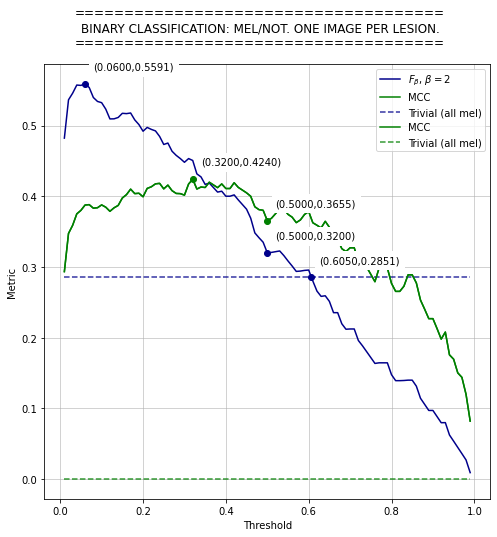

None

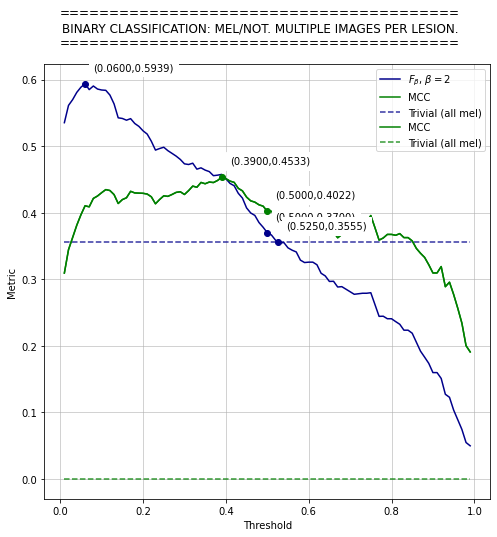

None

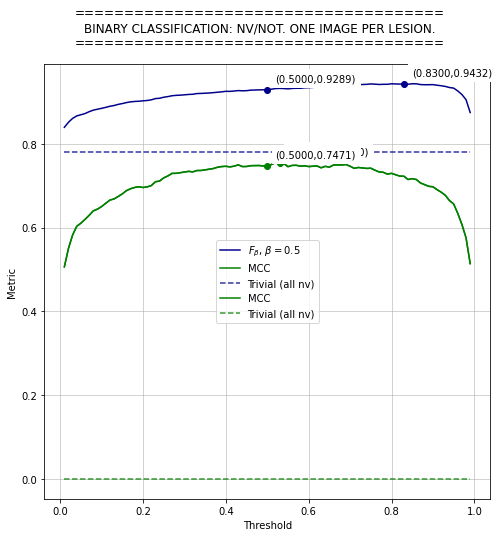

None

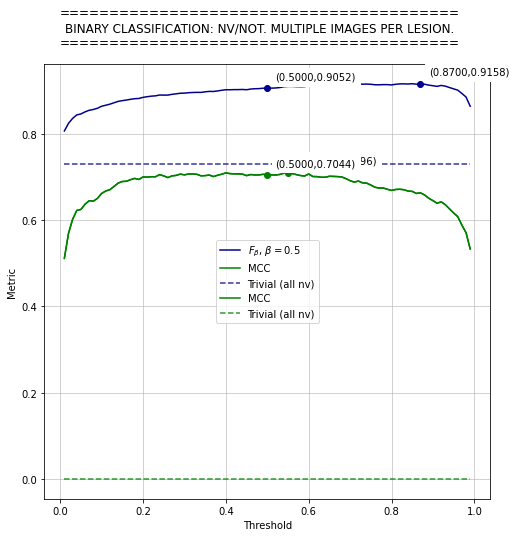

None

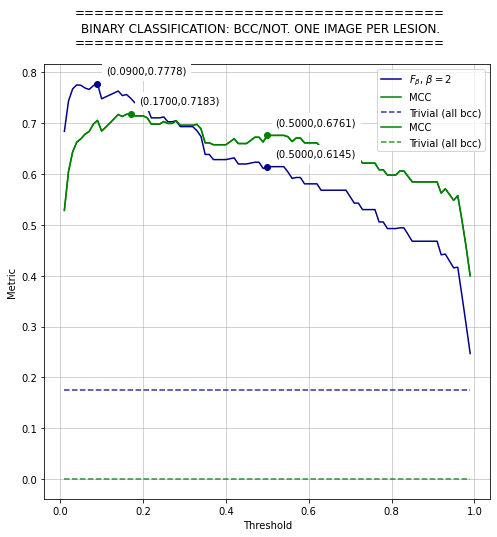

None

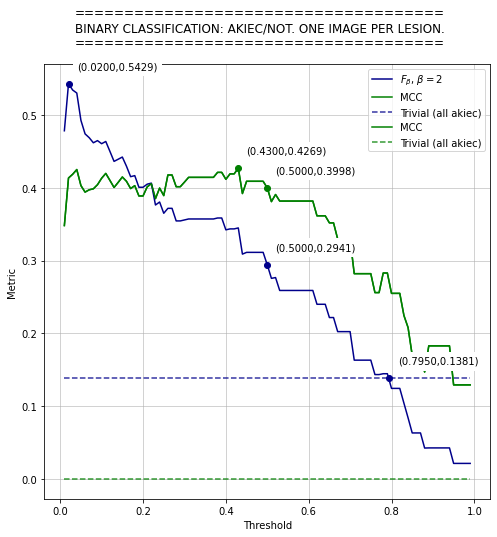

None

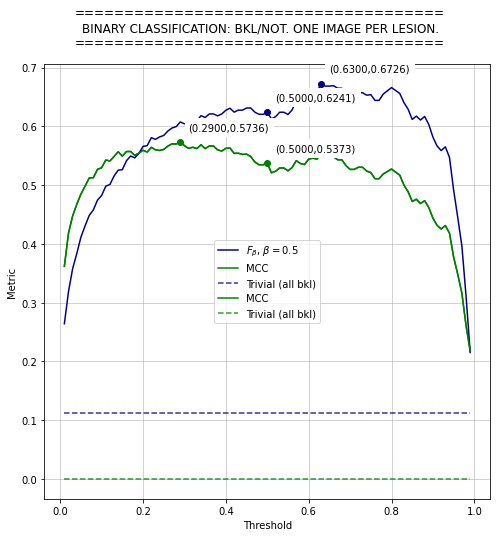

None

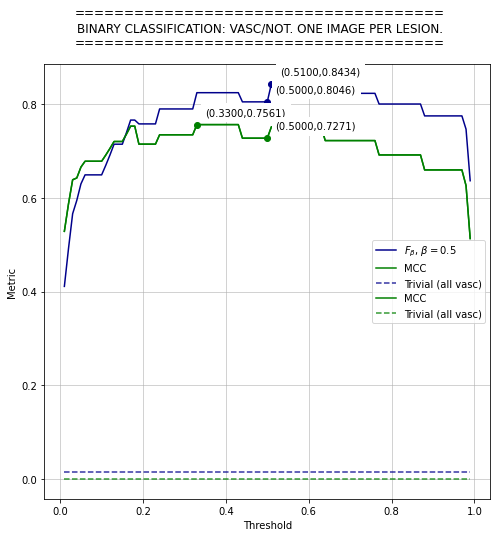

None

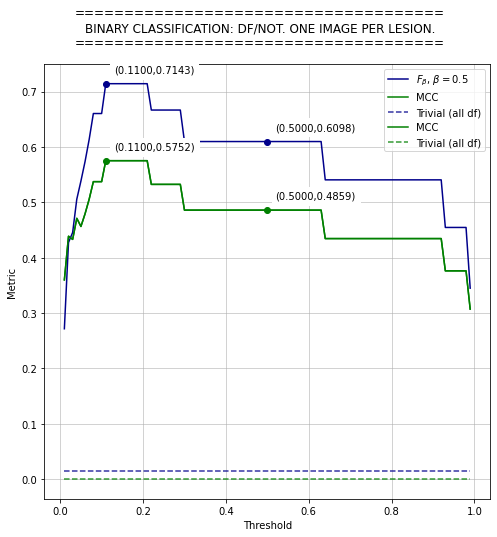

None

In [435]:
for pos_label in ['mel', 'nv', 'bcc', 'akiec', 'bkl', 'vasc', 'df']:
    for with_multiplicity in [False, True]:
        if with_multiplicity:
            try:
                predictions = binary_resnet18_ft3_fr4[pos_label + '_mult']['preds'][:,1]
                targets = binary_resnet18_ft3_fr4[pos_label + '_mult']['targs']
                display(plot_metric_vs_threshold(predictions, targets, pos_label, with_multiplicity = with_multiplicity))
            except:
                pass
        else:
            try:
                predictions = binary_resnet18_ft3_fr4[pos_label + '_dist']['preds'][:,1]
                targets = binary_resnet18_ft3_fr4[pos_label + '_dist']['targs']
                display(plot_metric_vs_threshold(predictions, targets, pos_label, with_multiplicity = with_multiplicity))
            except:
                pass

<a id='viewing_some'></a>
## Viewing some images, with predictions
↑↑ [Contents](#contents) ↑ [Model evaluation](#model_evaluation) 

We can now view some images alongside our models' predictions. Are the predictions consistent? That is, where there are multiple images of a given lesion, does our model predict melanoma/nevus/etc. with a similar probability for each image? Also, for a given lesion, we can compare the predictions of our melanoma/not melanoma model with those of our nevus/not nevus model.

In [520]:
def see(lesion_ids, maxrows = 5, maxcols = 5):
    print('Below each image are probabilities given by our binary classification models. To the left of || is the probability according to a model trained on exactly one image per lesion in our training set. To the right of || is the probability according to a model trained on all images of each lesion in our training set. For instance, \'mel: 10% || 15%\' means that our mel/not binary classifiers determined that the probability that the lesion is melanoma is 10% (one image/lesion) and 15% (multiple images/lesion).')

    lesion_ids = np.unique(lesion_ids)
    image_ids = {lesion_id : df[df['lesion_id'] == lesion_id]['image_id'].values for lesion_id in lesion_ids}
    
    nrows = min(maxrows, lesion_ids.shape[0])
    ncols = min(max([image_ids[lesion_id].shape[0] for lesion_id in lesion_ids]), maxcols)

    rand_lesion_ids = np.random.choice(lesion_ids,nrows,replace=False)
    rand_image_ids = {lesion_id : np.random.choice(image_ids[lesion_id], min(ncols,image_ids[lesion_id].shape[0]), replace=False) 
                      for lesion_id in rand_lesion_ids}

    fig, ax = plt.subplots(nrows, ncols)
    fig.set_figheight(8*nrows)
    fig.set_figwidth(5*ncols)
    fig.subplots_adjust(hspace=3.5 + nrows/5)

    for i in range(nrows):
        for j in range(ncols):
            try:
                lesion_id = rand_lesion_ids[i]
                image_id = rand_image_ids[lesion_id][j]
                PRED = '~predictions~\n'
                for pos_label in ['mel', 'nv', 'bcc', 'akiec', 'bkl', 'vasc', 'df']:
                    PRED += pos_label + ': '
                    try:
                        prob_dist = partition_dist[partition_dist['image_id'] == image_id]['prob_' + pos_label].values[0]
                        PRED += f'{100*prob_dist:.2f}%' 
                    except:
                        PRED += '___'
                    PRED += ' || '
                    try:
                        prob_mult = partition_mult[partition_mult['image_id'] == image_id]['prob_' + pos_label].values[0]
                        PRED += f'{100*prob_mult:.2f}%'
                    except:
                        PRED += '___'
                    PRED += '\n'

                ax = plt.subplot(nrows, ncols, i*ncols + j + 1)
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_xlabel('xlabel', fontsize=18)

                [lesion_id, no_of_images, image_id, dx, dx_type, age, sex, localization] = metadata[metadata['image_id'] == image_id].values[0][:8]
                partition = 'Set: '
                if partition_dist[partition_dist['image_id'] == image_id]['partition'].isnull().values[0]:
                    partition += '___'
                else:
                    prtd = partition_dist[partition_dist['image_id'] == image_id]['partition'].values[0]
                    partition += f'{prtd}'
                partition += ' || '
                if partition_mult[partition_mult['image_id'] == image_id]['partition'].isnull().values[0]:
                    partition += '___'
                else:
                    prtd = partition_mult[partition_mult['image_id'] == image_id]['partition'].values[0]
                    partition += f'{prtd}'

                ax.set_xlabel(lesion_id + '\n' + f'{no_of_images} images' + '\n' + image_id + '\n' + dx + '\n' + dx_type + '\n' + f'{age}' + '\n' + sex + '\n' + localization + '\n' + partition + '\n'+ PRED, loc='left')

                image = np.asarray(Image.open(path_to_images + image_id + '.jpg'))
                plt.imshow(image)
            except:
                ax = plt.subplot(nrows, ncols, i*ncols + j + 1)
                plt.axis('off')
    plt.show()

DIAGNOSIS MEL AND MORE THAN 4 IMAGES.

Below each image are probabilities given by our binary classification models. To the left of || is the probability according to a model trained on exactly one image per lesion in our training set. To the right of || is the probability according to a model trained on all images of each lesion in our training set. For instance, 'mel: 10% || 15%' means that our mel/not binary classifiers determined that the probability that the lesion is melanoma is 10% (one image/lesion) and 15% (multiple images/lesion).


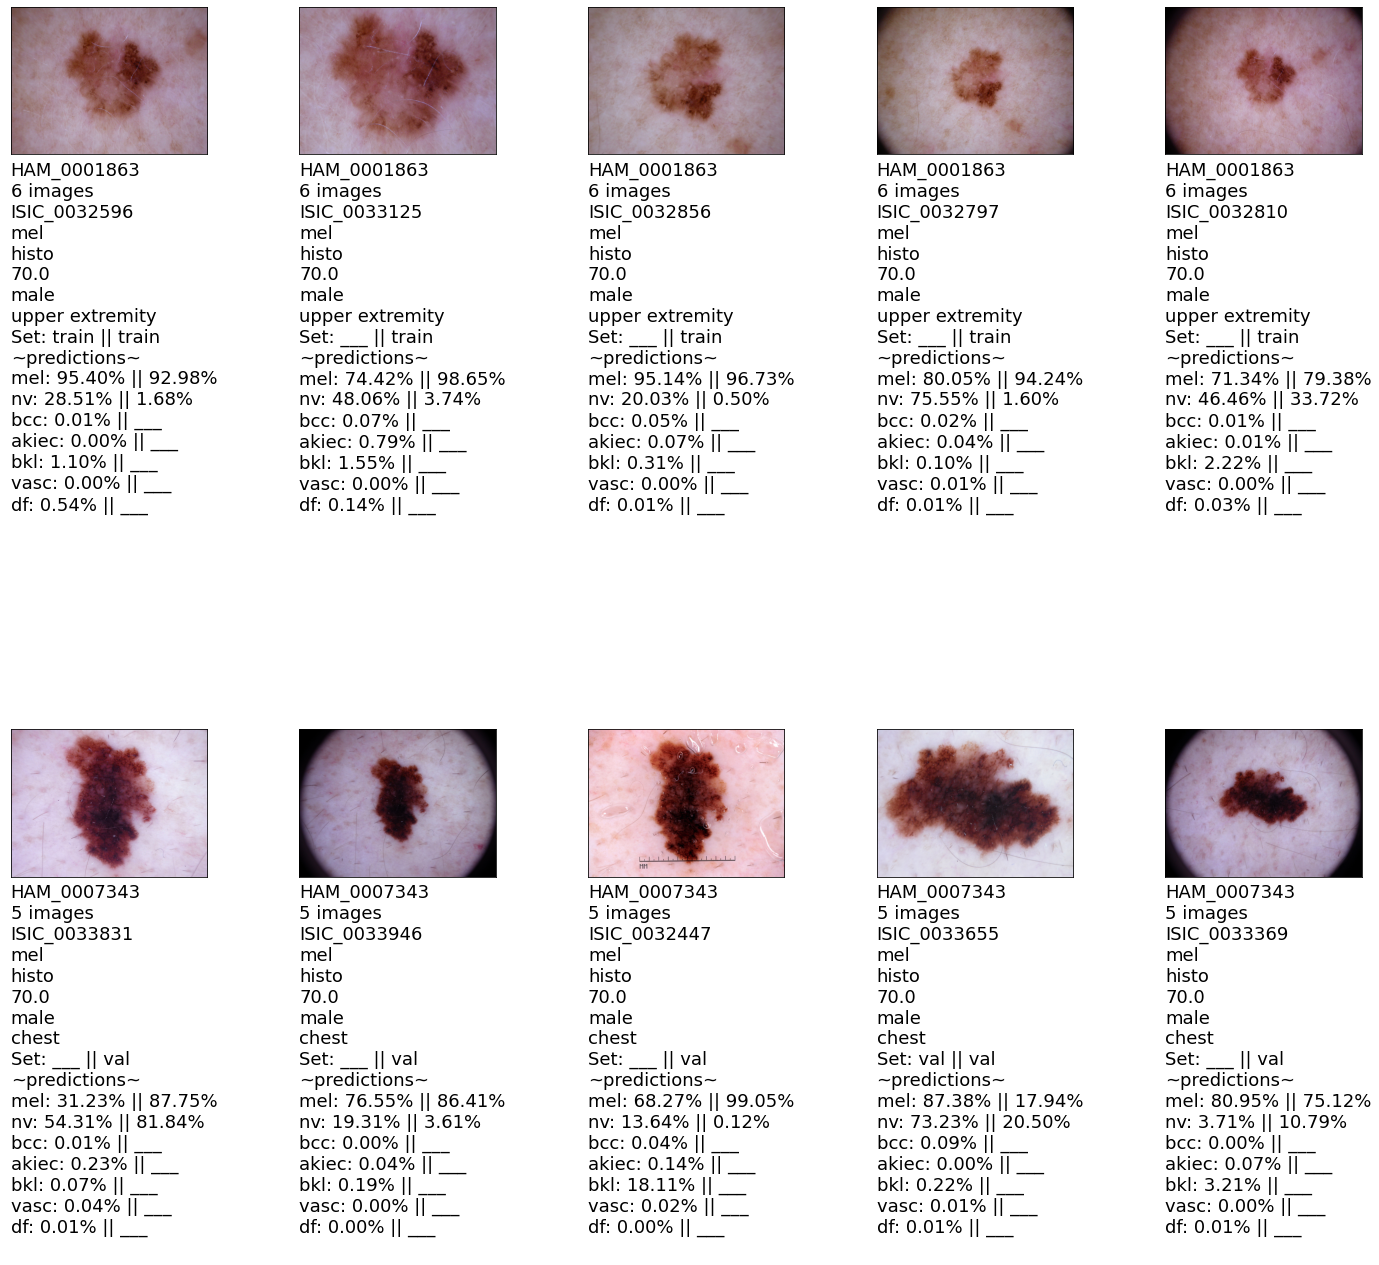

DIAGNOSIS NV AND MORE THAN 4 IMAGES.

Below each image are probabilities given by our binary classification models. To the left of || is the probability according to a model trained on exactly one image per lesion in our training set. To the right of || is the probability according to a model trained on all images of each lesion in our training set. For instance, 'mel: 10% || 15%' means that our mel/not binary classifiers determined that the probability that the lesion is melanoma is 10% (one image/lesion) and 15% (multiple images/lesion).


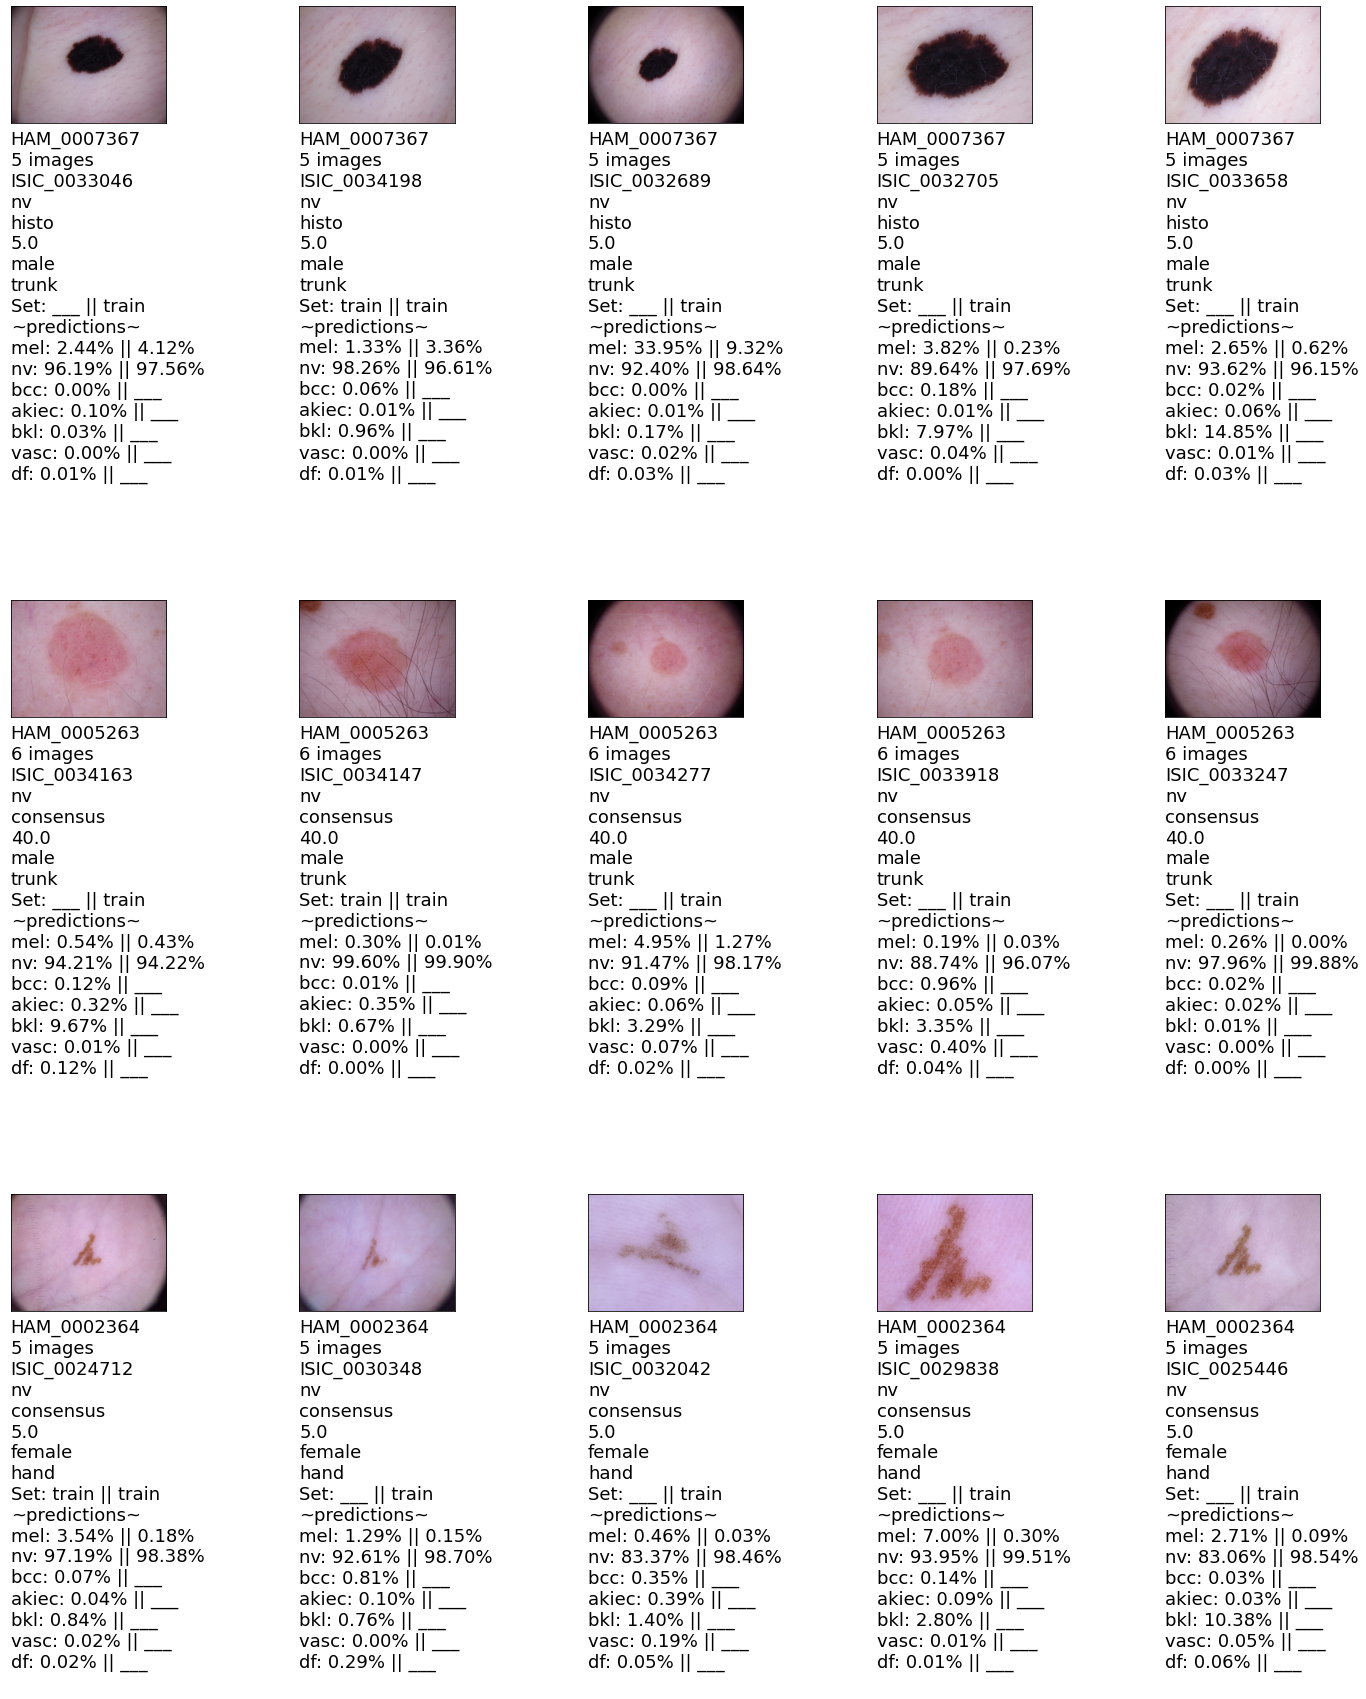

In [521]:
# Let's look at lesions of certain types for which we have more than m images, where
m = 4

# Let's check our models' predictions for consistency.
A = metadata['no_of_images'] > m
MEL = metadata['dx'] == 'mel'
NV = metadata['dx'] == 'nv'
BCC = metadata['dx'] == 'bcc'
AKIEC = metadata['dx'] == 'akiec'
VASC = metadata['dx'] == 'vasc'
DF = metadata['dx'] == 'df'
BKL = metadata['dx'] == 'bkl'

for dx in zip(['mel', 'nv'],[MEL, NV]):
    lesion_ids = metadata[A & dx[1]]['lesion_id']
    print(f'Diagnosis {dx[0]} and more than {m} images.'.upper() + '\n')
    see(lesion_ids, maxrows = 5, maxcols = 5)

POTENTIAL FALSE NEGATIVE FOR MELANOMA.

Below each image are probabilities given by our binary classification models. To the left of || is the probability according to a model trained on exactly one image per lesion in our training set. To the right of || is the probability according to a model trained on all images of each lesion in our training set. For instance, 'mel: 10% || 15%' means that our mel/not binary classifiers determined that the probability that the lesion is melanoma is 10% (one image/lesion) and 15% (multiple images/lesion).


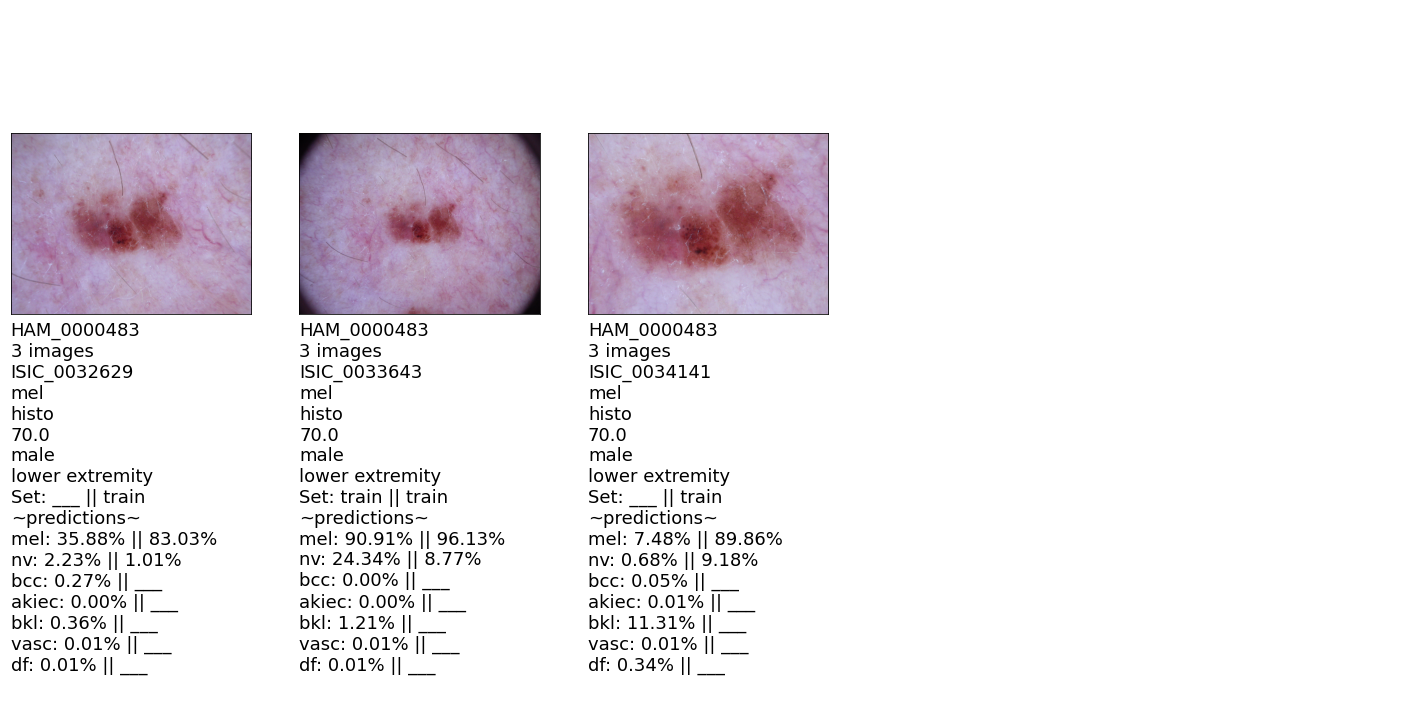

In [532]:
# Let's look at some false negatives for melanoma

t = 0.5

PN = partition_dist['prob_mel'] < t
P = partition_dist['dx'] == 'mel'
lesion_ids = partition_dist[PN & P]['lesion_id']
print(f'Potential false negative for melanoma.\n'.upper())
see(lesion_ids, maxrows = 1, maxcols = 5)
# HAM_0003102 less than 50% for all dx, looks very faint like nothing there almost.
# HAM_0007171
# HAM_0007620 is a on a raised lumpy bit of skin